In [1]:
import pandas as pd
from datetime import datetime

In [4]:
df_cleaned = pd.read_csv(r'C:\Users\Yibabe\Desktop\10 academyAIM week_6\data\undroped.csv')

In [5]:
df_cleaned.head()

,Unnamed: 0.1,Unnamed: 0,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,...,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_tv,ProductCategory_utility_bill,CustomerId_Encoded,SubscriptionId_Encoded,AccountId_Encoded,BatchId_Encoded
0,0,0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,...,0,0,0,0,0,0,101,54,54,1
1,1,1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,...,1,0,0,0,0,0,101,27779,26042,1
2,2,2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,...,0,0,0,0,0,0,2,2,2,1
3,3,4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,...,1,0,0,0,0,0,22,27779,26042,1
4,4,5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,...,0,0,0,0,0,0,1,1,1,1


In [6]:
import numpy as np

# Ensure 'TransactionStartTime' is in datetime format
df_cleaned['TransactionStartTime'] = pd.to_datetime(df_cleaned['TransactionStartTime'])

def compute_rfms(df):
    # Set the reference date (e.g., today’s date or max transaction date in the dataset)
    today_date = df['TransactionStartTime'].max()
    
    # Calculate Recency: difference between today's date and the last transaction for each customer
    recency = (today_date - df.groupby('CustomerId_Encoded')['TransactionStartTime'].max()).dt.days
    
    # Calculate Frequency: count of transactions per customer
    frequency = df.groupby('CustomerId_Encoded')['TransactionId'].count()
    
    # Calculate Monetary: sum of amounts spent per customer
    monetary = df.groupby('CustomerId_Encoded')['Amount'].sum()
    
    # Create a new DataFrame for RFMS scores
    rfms = pd.DataFrame({
        'Recency': recency,
        'Frequency': frequency,
        'Monetary': monetary
    }).reset_index()
    
    return rfms

# Apply the function on the DataFrame
rfms_df = compute_rfms(df_cleaned)


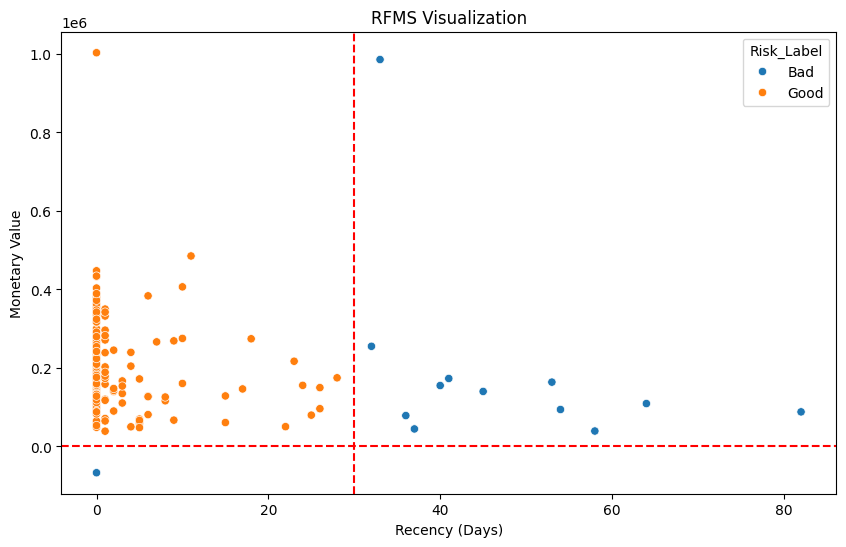

In [8]:
import matplotlib.pyplot as plt
# Compute RFMS values
import seaborn as sns

rfms_df = compute_rfms(df_cleaned)

# Classify users based on RFMS
# Here, define your criteria for "good" and "bad" classifications.
# This is a simple example, you can adjust the thresholds as needed.
rfms_df['Risk_Label'] = np.where((rfms_df['Recency'] <= 30) & (rfms_df['Frequency'] >= 5) & (rfms_df['Monetary'] > 1000), 'Good', 'Bad')

# Visualize RFMS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfms_df, x='Recency', y='Monetary', hue='Risk_Label')
plt.title('RFMS Visualization')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value')
plt.axhline(y=1000, color='r', linestyle='--')  # Example boundary
plt.axvline(x=30, color='r', linestyle='--')  # Example boundary
plt.show()

In [9]:
def woe_bin(series, target):
    """Calculates Weight of Evidence for a given feature."""
    # Group the data by the categorical feature and calculate good and bad counts
    df_woe = pd.DataFrame(series.value_counts()).reset_index()
    df_woe.columns = ['Category', 'Count']
    
    # Calculate good and bad counts
    df_woe['good'] = target.value_counts().reindex(df_woe['Category'], fill_value=0)
    df_woe['bad'] = target.count() - df_woe['good']
    
    # Calculate distributions
    df_woe['good_dist'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_dist'] = df_woe['bad'] / df_woe['bad'].sum()
    
    # Calculate WoE
    df_woe['WoE'] = np.log(df_woe['good_dist'] / df_woe['bad_dist'])
    
    return df_woe



In [12]:

# Perform WoE binning on 'ProductCategory'
# Ensure 'ProductCategory' is in your DataFrame
if 'ProductCategory' in df_cleaned.columns:
    target = rfms_df['Risk_Label'].map({'Good': 1, 'Bad': 0})  # Encode Risk_Label as binary
    woe_results = woe_bin(df_cleaned['ProductCategory'], target)
    
    print(woe_results)
else:
    print("ProductCategory column not found in DataFrame.")

             Category  Count  good  bad  good_dist  bad_dist  WoE
0  financial_services  31948   NaN  NaN        NaN       NaN  NaN
1             airtime  30295   NaN  NaN        NaN       NaN  NaN
2        data_bundles   1354   NaN  NaN        NaN       NaN  NaN
3                  tv    540   NaN  NaN        NaN       NaN  NaN
4        utility_bill    120   NaN  NaN        NaN       NaN  NaN
5              movies      7   NaN  NaN        NaN       NaN  NaN
6              ticket      7   NaN  NaN        NaN       NaN  NaN
7               other      2   NaN  NaN        NaN       NaN  NaN


Construct the RFMS Scores

In [13]:
# Convert 'TransactionStartTime' to datetime
df_cleaned['TransactionStartTime'] = pd.to_datetime(df_cleaned['TransactionStartTime'])

# Calculate Recency
latest_date = df_cleaned['TransactionStartTime'].max()
df_cleaned['Recency'] = (latest_date - df_cleaned['TransactionStartTime']).dt.days


Calculate Frequency:

In [15]:
frequency = df_cleaned.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']
df_cleaned = df_cleaned.merge(frequency, on='CustomerId', how='left')


Calculate RFMS Score

In [20]:
#Example: Normalize Recency, Frequency, and Monetary
df_cleaned['Recency_Score'] = (df_cleaned['Recency'].max() - df_cleaned['Recency']) / (df_cleaned['Recency'].max() - df_cleaned['Recency'].min())
df_cleaned['Frequency_Score'] = (df_cleaned['Frequency'] - df_cleaned['Frequency'].min()) / (df_cleaned['Frequency'].max() - df_cleaned['Frequency'].min())
df_cleaned['Monetary_Score'] = (df_cleaned['Monetary'] - df_cleaned['Monetary'].min()) / (df_cleaned['Monetary'].max() - df_cleaned['Monetary'].min())

df_cleaned['RFMS_Score'] = df_cleaned['Recency_Score'] + df_cleaned['Frequency_Score'] + df_cleaned['Monetary_Score']


 Classify Users into Good and Bad Labels

In [21]:
# Define a threshold (e.g., median or a specific value)
threshold = df_cleaned['RFMS_Score'].median()
df_cleaned['Risk_Label'] = df_cleaned['RFMS_Score'].apply(lambda x: 'Good' if x >= threshold else 'Bad')


In [16]:
df_cleaned.head()

,Unnamed: 0.1,Unnamed: 0,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,...,AccountId_Encoded,BatchId_Encoded,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMS_Score,Risk_Label
0,0,0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,...,54,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
1,1,1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,...,26042,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
2,2,2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,...,2,1,90,2,1000.00,0.0,0.000497,0.067023,0.067520,Bad
3,3,4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,...,26042,1,90,22,15727.20,0.0,0.010443,0.080732,0.091174,Bad
4,4,5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,...,1,1,90,1,2000.00,0.0,0.000000,0.067954,0.067954,Bad


In [20]:
# List of columns to drop (unnecessary for normalization)
columns_to_drop = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 
                'CurrencyCode', 'CountryCode', 'ProviderId', 
                   'ProductId', 'ProductCategory', 'ChannelId']
                  

# Dropping the columns
df2 = df_cleaned.drop(columns=columns_to_drop)

In [24]:
df2.drop(['CustomerId'],axis ='columns')

,Unnamed: 0.1,Unnamed: 0,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TransactionHour,TransactionDay,TransactionMonth,...,AccountId_Encoded,BatchId_Encoded,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMS_Score,Risk_Label
0,0,0,1000.0,1000,2018-11-15 02:18:49,2,0,2,15,11,...,54,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
1,1,1,-20.0,20,2018-11-15 02:19:08,2,0,2,15,11,...,26042,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
2,2,2,500.0,500,2018-11-15 02:44:21,2,0,2,15,11,...,2,1,90,2,1000.00,0.0,0.000497,0.067023,0.067520,Bad
3,3,4,-644.0,644,2018-11-15 03:34:21,2,0,3,15,11,...,26042,1,90,22,15727.20,0.0,0.010443,0.080732,0.091174,Bad
4,4,5,2000.0,2000,2018-11-15 03:35:10,2,0,3,15,11,...,1,1,90,1,2000.00,0.0,0.000000,0.067954,0.067954,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64268,64268,95657,-1000.0,1000,2019-02-13 09:54:09,2,0,9,13,2,...,26042,1,0,508,317340.00,1.0,0.252113,0.361494,1.613607,Good
64269,64269,95658,1000.0,1000,2019-02-13 09:54:25,2,0,9,13,2,...,23,1,0,39,28999.60,1.0,0.018896,0.093087,1.111983,Good
64270,64270,95659,-20.0,20,2019-02-13 09:54:35,2,0,9,13,2,...,26042,1,0,39,28999.60,1.0,0.018896,0.093087,1.111983,Good
64271,64271,95660,3000.0,3000,2019-02-13 10:01:10,2,0,10,13,2,...,261,1,0,422,242041.00,1.0,0.209349,0.291400,1.500749,Good


In [35]:
df3 = df2.drop(['CustomerId'], axis ='columns')

In [36]:
# Identify columns with string (object) data types
string_columns = df3.select_dtypes(include=['object']).columns.tolist()
print("Columns with string data types:", string_columns)

Columns with string data types: ['Risk_Label']


In [42]:
df3.head()

,Unnamed: 0.1,Unnamed: 0,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TransactionHour,TransactionDay,TransactionMonth,...,AccountId_Encoded,BatchId_Encoded,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMS_Score,Risk_Label
0,0,0,1000.0,1000,2018-11-15 02:18:49,2,0,2,15,11,...,54,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
1,1,1,-20.0,20,2018-11-15 02:19:08,2,0,2,15,11,...,26042,1,90,101,50096.75,0.0,0.049727,0.112725,0.162452,Bad
2,2,2,500.0,500,2018-11-15 02:44:21,2,0,2,15,11,...,2,1,90,2,1000.00,0.0,0.000497,0.067023,0.067520,Bad
3,3,4,-644.0,644,2018-11-15 03:34:21,2,0,3,15,11,...,26042,1,90,22,15727.20,0.0,0.010443,0.080732,0.091174,Bad
4,4,5,2000.0,2000,2018-11-15 03:35:10,2,0,3,15,11,...,1,1,90,1,2000.00,0.0,0.000000,0.067954,0.067954,Bad


 Perform Weight of Evidence (WoE) Binning

In [22]:
# Function to calculate WoE
def calculate_woe(df, target, feature):
    df_woe = df.groupby(feature)[target].agg(['count', 'sum'])
    df_woe['bad'] = df_woe['sum']
    df_woe['good'] = df_woe['count'] - df_woe['bad']
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['WoE'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    return df_woe[[target, 'WoE']]

# Example usage for a categorical feature
woe_df = calculate_woe(df3, 'Risk_Label', 'ProductCategory')


In [38]:
df3.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Amount', 'Value', 'TransactionStartTime',
       'PricingStrategy', 'FraudResult', 'TransactionHour', 'TransactionDay',
       'TransactionMonth', 'TransactionYear', 'ProductId_ProductId_1',
       'ProductId_ProductId_10', 'ProductId_ProductId_11',
       'ProductId_ProductId_12', 'ProductId_ProductId_13',
       'ProductId_ProductId_14', 'ProductId_ProductId_15',
       'ProductId_ProductId_16', 'ProductId_ProductId_19',
       'ProductId_ProductId_2', 'ProductId_ProductId_20',
       'ProductId_ProductId_21', 'ProductId_ProductId_24',
       'ProductId_ProductId_3', 'ProductId_ProductId_4',
       'ProductId_ProductId_6', 'ProductId_ProductId_9',
       'ChannelId_ChannelId_1', 'ChannelId_ChannelId_2',
       'ChannelId_ChannelId_3', 'ChannelId_ChannelId_5',
       'ProviderId_ProviderId_1', 'ProviderId_ProviderId_2',
       'ProviderId_ProviderId_3', 'ProviderId_ProviderId_4',
       'ProviderId_ProviderId_5', 'ProviderId_ProviderId_6',
       